# Private Distributed Resource Allocation Numerical Experiment Code

Install package **pdra** before running this script:

In [ ]:
%pip install "pdra[exp] @ git+https://github.com/rui-huang-opt/pdra.git"

## 1. Set Parameters

In [2]:
import numpy as np

n_vars = 2
n_cons = 2

algorithm = "core"  # Change to "core", "rsdd", or "dual_decomp" as needed
node_names = ["1", "2", "3", "4", "5"]
edge_pairs = [("1", "2"), ("2", "3"), ("3", "4"), ("4", "5"), ("5", "1")]

Q = {
    "1": np.array(
        [
            [2.875534271125623, 0.06144343163412097],
            [0.06144343163412097, 2.254218742165002],
        ]
    ),
    "2": np.array(
        [
            [3.8026179850740753, -1.1782113709237287],
            [-1.1782113709237287, 2.7730675866708934],
        ]
    ),
    "3": np.array(
        [
            [2.5699029862613805, 0.09971261279558088],
            [0.09971261279558088, 2.244252016241631],
        ]
    ),
    "4": np.array(
        [
            [2.4804809929701177, -0.7786936710712302],
            [-0.7786936710712302, 3.562713369279426],
        ]
    ),
    "5": np.array(
        [
            [2.5715134324613014, 0.6960365893732322],
            [0.6960365893732322, 3.537348963308837],
        ]
    ),
}

c = {
    "1": np.array([-4.219906797787817, -4.220027398318987]),
    "2": np.array([-4.090875163964497, -4.082977450732831]),
    "3": np.array([-2.71965007891482, -1.0741201930349318]),
    "4": np.array([-0.1718398346272032, -0.9580132594176947]),
    "5": np.array([-3.7061000919999154, -1.68738857823009]),
}

A = {
    "1": np.array(
        [
            [0.2904180608409973, 4.330880728874676],
            [3.005575058716044, 3.540362888980227],
        ]
    ),
    "2": np.array(
        [
            [1.5212112147976886, 2.6237821581611893],
            [2.1597250932105787, 1.4561457009902097],
        ]
    ),
    "3": np.array(
        [
            [0.9983689107917987, 2.571172192068058],
            [2.9620728443102124, 0.23225206359998862],
        ]
    ),
    "4": np.array(
        [
            [1.5230688458668533, 0.48836057003191935],
            [3.4211651325607844, 2.2007624686980067],
        ]
    ),
    "5": np.array(
        [
            [1.5585553804470549, 2.600340105889054],
            [2.7335513967163982, 0.9242722776276352],
        ]
    ),
}

b = np.array([4.847923138822793, 3.8756641168055728])

## 2. Solve Centralized Optimization

$$
\begin{split}
    \min_{\boldsymbol{x}_i \in \mathbb{R}^{n}} \quad & \sum_{i \in [5]} \left( \frac{1}{2} \boldsymbol{x}_i^\top Q_i \boldsymbol{x}_i + \boldsymbol{c}_i\boldsymbol{x}_i \right) \\
    \text{s.t.} \quad & \sum_{i \in \mathcal{I}} A_{i}\boldsymbol{x}_{i} \leq \boldsymbol{b}
\end{split}
$$

In [2]:
import cvxpy as cp

x = {i: cp.Variable(n_vars) for i in node_names}

cost = cp.sum([cp.quad_form(x[i], Q[i]) / 2 + c[i].T @ x[i] for i in node_names])
constraints: list[cp.Constraint] = [
    sum([A[i] @ x[i] for i in node_names], start=cp.Constant(0)) <= b
]

problem = cp.Problem(cp.Minimize(cost), constraints)

problem.solve(solver=cp.OSQP)

optimal_value = problem.value
optimal_solution = {i: x[i].value for i in node_names}

print("Optimal value:", optimal_value)
print("Optimal solution:")
for i in node_names:
    print(f"Node {i}: {optimal_solution[i]}")

Optimal value: -9.474506786840472
Optimal solution:
Node 1: [0.74288488 0.20711661]
Node 2: [0.95655114 1.23231216]
Node 3: [0.174483   0.03852662]
Node 4: [-1.17120148 -0.43732797]
Node 5: [ 0.55920635 -0.03871538]


## 3. Solve Distributed Optimization

In [3]:
if __name__ == "__main__":
    import os
    from functools import partial
    from pdra import Node
    from gossip import create_sync_network

    node_params = {
        "core": {
            "max_iter": 3000,
            "step_size": 0.001,
            "method": "AGM",
            "solver": "OSQP",
            "results_prefix": os.path.join("results", "distributed_qp", "core"),
        },
        "rsdd": {
            "max_iter": 3000,
            "step_size": 0.5,
            "solver": "OSQP",
            "results_prefix": os.path.join("results", "distributed_qp", "rsdd"),
            "decay_rate": 0.9,
            "penalty_factor": 1e3,
        },
        "dual_decomp": {
            "max_iter": 3000,
            "step_size": 0.1,
            "solver": "OSQP",
            "results_prefix": os.path.join("results", "distributed_qp", "dual_decomp"),
            "comm_weight": 0.5,
        },
    }

    def f(x: cp.Variable, index: str) -> cp.Expression:
        return x @ Q[index] @ x / 2 + c[index] @ x

    communicators = create_sync_network(node_names, edge_pairs)

    nodes = [
        Node.create(
            algorithm,
            communicators[i],
            partial(f, index=i),
            A[i],
            **node_params[algorithm],
        )
        for i in node_names
    ]

    nodes[0].set_resource(b)

    for node in nodes:
        node.start()

    for node in nodes:
        node.join()

## 4. Plot Topology

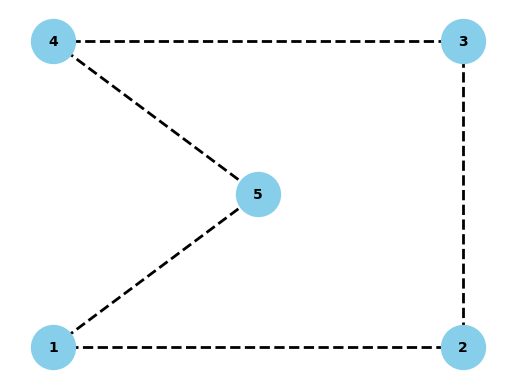

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()

G = nx.Graph()
G.add_nodes_from(node_names)
G.add_edges_from(edge_pairs)

pos = {"1": (0, 0), "2": (1, 0), "3": (1, 1), "4": (0, 1), "5": (0.5, 0.5)}

graph_options = {
    "pos": pos,
    "ax": ax1,
    "with_labels": True,
    "node_size": 1000,
    "node_color": "skyblue",
    "font_size": 10,
    "font_color": "black",
    "font_weight": "bold",
    "edge_color": "black",
    "width": 2,
    "style": "dashed",
}

nx.draw(G, **graph_options)

plt.show()

## 5. Load Results

In [5]:
from numpy.typing import NDArray

results_prefix = os.path.join("results", "distributed_qp", algorithm)
results: dict[str, dict[str, NDArray[np.float64]]] = {
    i: np.load(os.path.join(results_prefix, f"node_{i}.npz")) for i in node_names
}

## 6. Plot Error Evolution

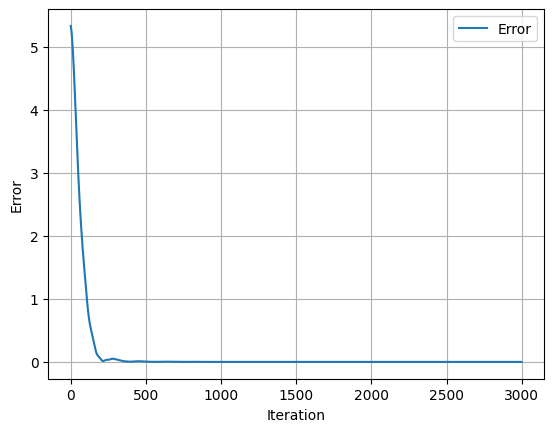

In [6]:
fig2, ax2 = plt.subplots()

err_series = sum([results[i]["f_i_series"] for i in node_names]) - optimal_value  # type: ignore
ax2.plot(err_series, label="Error")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Error")
ax2.legend()
ax2.grid(True)

plt.show()

## 7. Plot Computation Time

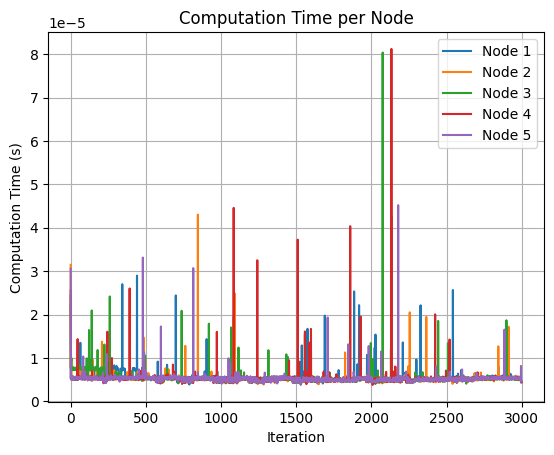

In [7]:
fig3, ax3 = plt.subplots()

computation_times = {i: results[i]["computation_time"] for i in node_names}
for i in node_names:
    ax3.plot(computation_times[i], label=f"Node {i}")

ax3.set_xlabel("Iteration")
ax3.set_ylabel("Computation Time (s)")
ax3.set_title("Computation Time per Node")
ax3.grid(True)
ax3.legend()

plt.show()